In [1]:
import os
from tensorflow.keras.utils import Sequence
from tensorflow.keras import Sequential, optimizers, preprocessing, initializers
from tensorflow.keras.layers import MaxPooling2D, Dense, BatchNormalization, Dropout, Flatten, InputLayer, Conv2D, Activation
import tensorflow as tf
from tensorflow.python.keras import backend as K
from sklearn import preprocessing, model_selection, metrics
from math import ceil
import pandas as pd
import numpy as np
from skimage import io
from skopt import gbrt_minimize, gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Categorical, Integer
import seaborn as sns
from matplotlib import pyplot as plt

print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

GPU is available


In [2]:
class BatchGenerator(Sequence):

    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        return np.array([preprocessing.StandardScaler().fit_transform(io.imread(os.path.join(PATH, file_name))).reshape(
            (400, 400, 1))
                         for file_name in batch_x]), np.array(batch_y)



In [3]:
def create_model(filters, learning_rate, dropout0, dropout1, activation):
    model = Sequential()
    model.add(Conv2D(filters[0], kernel_size=(5, 5), input_shape=(400, 400, 1),
                     kernel_initializer=initializers.GlorotNormal(), padding="same"))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(BatchNormalization())
    model.add(Activation(activation))

    for index, filter_ in enumerate(filters[1:-2]):
        model.add(Conv2D(filter_, kernel_size=(3, 3), activation=activation, padding="same"))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(BatchNormalization())
        model.add(Activation(activation))

    model.add(Flatten())
    model.add(Dense(filters[-2]))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(Dropout(dropout0))

    model.add(Dense(filters[-1]))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(Dropout(dropout1))

    model.add(Dense(4, activation='softmax'))

    opt = optimizers.Adam(learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=opt,
                  metrics=['categorical_accuracy'])

    return model

In [8]:
PATH = os.path.join("dataset", "data_augmented")
df = pd.read_csv("dataset/name_data_augmented.csv", index_col=0)
X = df.filename.values
Y = df.label.values

# TRAIN

In [9]:
batch_size = 32
x_train, y_train = X, pd.get_dummies(Y).values
train_batch_generator = BatchGenerator(x_train, y_train, batch_size=batch_size)
model = create_model(filters=[16, 32, 128, 128, 32, 8], learning_rate=0.0005, activation="relu", 
                         dropout0=0.5, dropout1=0.3)
model.fit(x=train_batch_generator, verbose=1, epochs=12)

Train for 498 steps
Epoch 1/12
498/498 [==============================] - 533s 1s/step - loss: 0.9279 - categorical_accuracy: 0.6721
Epoch 2/12
498/498 [==============================] - 124s 249ms/step - loss: 0.5635 - categorical_accuracy: 0.8189
Epoch 3/12
498/498 [==============================] - 124s 249ms/step - loss: 0.4196 - categorical_accuracy: 0.8475
Epoch 4/12
498/498 [==============================] - 120s 242ms/step - loss: 0.3382 - categorical_accuracy: 0.8707
Epoch 5/12
498/498 [==============================] - 121s 244ms/step - loss: 0.2908 - categorical_accuracy: 0.9068
Epoch 6/12
498/498 [==============================] - 120s 242ms/step - loss: 0.2596 - categorical_accuracy: 0.9153
Epoch 7/12
498/498 [==============================] - 120s 242ms/step - loss: 0.2292 - categorical_accuracy: 0.9190
Epoch 8/12
498/498 [==============================] - 120s 241ms/step - loss: 0.2135 - categorical_accuracy: 0.9263
Epoch 9/12
498/498 [==============================] - 1

In [10]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


# TEST

In [7]:
batch_size = 32

In [4]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = tf.keras.models.model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("model.h5")

Loaded model from disk


In [5]:
PATH = os.path.join("dataset", "test")
df = pd.read_csv(os.path.join("dataset", "test.csv"), index_col=0)
X = df.filename.values
Y = pd.get_dummies(df.label)

In [8]:
x_test = X
y_test = Y
test_batch_generator = BatchGenerator(x_test, y_test, batch_size=batch_size)
predicts_labels = np.argmax(model.predict(test_batch_generator), axis=1)

In [9]:
metrics.accuracy_score(np.argmax(Y.values, axis=1), predicts_labels)

0.799375

In [15]:
model.layers

IndexError: list index out of range

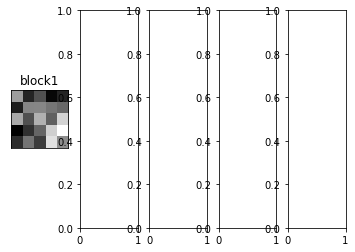

In [12]:
layers = model.layers[:-2]
#layer_ids = [1,4,7,11,15]
#plot the filters
fig,ax = plt.subplots(nrows=1,ncols=5)
for i, layer in enumerate(layers):
    ax[i].imshow(layer.get_weights()[0][:,:,:,0][:,:,0],cmap='gray')
    ax[i].set_title('block'+str(i+1))
    ax[i].set_xticks([])
    ax[i].set_yticks([])

In [69]:
predicts_labels_image = [np.bincount(row).argmax() for row in predicts_labels.reshape(400, 4)]
true_labels_image = [np.bincount(row).argmax() for row in np.argmax(Y.values, axis=1).reshape(400, 4)]

In [70]:
metrics.accuracy_score(true_labels_image, predicts_labels_image)

0.8225

In [76]:
confusion_matrix = metrics.confusion_matrix(true_labels_image, predicts_labels_image, normalize="true")
confusion_matrix = pd.DataFrame(data=confusion_matrix, columns=['DIESTRO', 'ESTRO', 'METAESTRO', 'PROESTRO'], 
                  index=['DIESTRO', 'ESTRO', 'METAESTRO', 'PROESTRO'])

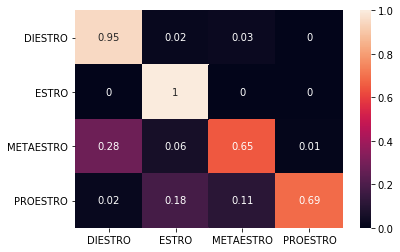

In [80]:
sns.heatmap(confusion_matrix, annot=True)